In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Data
orders_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/orders_dataset.csv')
customer_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/customers_dataset.csv')
order_reviews_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_reviews_dataset.csv')
order_items_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_items_dataset.csv')
order_payments_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_payments_dataset.csv')
geolocation_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/geolocation_dataset.csv')

# Segmentation and Classification of Purchasing Behavior

## Data Exploration

In [3]:
# Check for missing values
def check_missing_values(data):
    if data.isnull().values.any() == False:
        print('Data does not contain missing values')
    else:
        for column in data.columns:
            if data[column].isnull().values.any():
                print(f"column '{column}' contains a null value.")

In [4]:
# Check missing values in orders_df
check_missing_values(orders_df)

column 'order_approved_at' contains a null value.
column 'order_delivered_carrier_date' contains a null value.
column 'order_delivered_customer_date' contains a null value.


In [5]:
order_null = orders_df[orders_df[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isnull().any(axis=1)]
order_null.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [6]:
order_null['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
Name: order_status, dtype: int64

Missing values in orders_df are caused by:

* there is an unrecorded order status
* order status that has not gone through the shipping process
* order status that has not been approved

In [7]:
# Check missing values in customer_df
check_missing_values(customer_df)

Data does not contain missing values


In [8]:
# Check missing values in order_reviews_df
check_missing_values(order_reviews_df)

column 'review_comment_title' contains a null value.
column 'review_comment_message' contains a null value.


there are customers who do not fill in order comments

In [9]:
# Check missing values in order_items_df
check_missing_values(order_items_df)

Data does not contain missing values


In [10]:
# Check missing values in order_payments_df
check_missing_values(order_payments_df)

Data does not contain missing values


In [11]:
# Check missing values in geolocation_df
check_missing_values(geolocation_df)

Data does not contain missing values


## Enrichment Data

In [12]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [13]:
# merge order and customer data
order_merged_df = pd.merge(orders_df, order_items_df, on='order_id', how='left')
order_merged_df = pd.merge(order_merged_df, order_payments_df, on='order_id', how='left')
order_merged_df = pd.merge(order_merged_df, order_reviews_df, on='order_id', how='left')
customer_order_merged_df = pd.merge(order_merged_df, customer_df, on='customer_id', how='left')

customer_order_merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,...,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae36

In [14]:
# check for data duplication
customer_order_merged_df.duplicated().any()

False

In [15]:
# Data filter includes only successful transaction status
valid_statuses = ['shipped', 'delivered', 'processing', 'approved', 'invoiced']
customer_order_merged_df = customer_order_merged_df[customer_order_merged_df['order_status'].isin(valid_statuses)]
customer_order_merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,...,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae36

In [16]:
customer_order_merged_df = customer_order_merged_df[['order_id', 'customer_id','customer_unique_id','review_score', 'order_status', 'order_item_id',
                                                    'product_id', 'price', 'payment_type', 'payment_value', 'review_id',
                                                    'customer_city', 'customer_state']]
customer_order_merged_df

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,credit_card,18.12,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,2.00,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,18.59,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,delivered,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,boleto,141.46,8d5266042046a06655c8db133d120ba5,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0,delivered,1.0,aa4383b373c6aca5d8797843e5594415,159.90,credit_card,179.12,e73b67b67587f7644d5bd1a52deb1b01,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,4.0,delivered,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,credit_card,195.00,29bb71b2760d0f876dfa178a76bc4734,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,5.0,delivered,1.0,b80910977a37536adeddd63663f916ad,205.99,credit_card,271.01,371579771219f6db2d830d50805977bb,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ


In [17]:
check_missing_values(customer_order_merged_df)

column 'review_score' contains a null value.
column 'order_item_id' contains a null value.
column 'product_id' contains a null value.
column 'price' contains a null value.
column 'payment_type' contains a null value.
column 'payment_value' contains a null value.
column 'review_id' contains a null value.


In [18]:
# customer data that does not have an order_item_id
customer_order_merged_df[customer_order_merged_df['order_item_id'].isnull()]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
27808,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,f15a952dfc52308d0361288fbf42c7b3,1.0,shipped,NaN,NaN,NaN,boleto,77.73,b399a4b417fc794a814ef957423bd67a,porto alegre,RS
68897,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,6a2da481aa7827b951175772a0fe8bb8,1.0,invoiced,NaN,NaN,NaN,boleto,73.04,17bc0bc3207616ee37afd4a39b10054a,aracatuba,SP
83584,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,8886115442775dd8a20c2dcc921c7cc8,1.0,invoiced,NaN,NaN,NaN,credit_card,76.19,5a4f0fe15c7a914e40cabe9a06d81513,florianopolis,SC


In [19]:
# customer data that has no payment_value
customer_order_merged_df[customer_order_merged_df['payment_value'].isnull()]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
36864,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,1.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP
36865,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,2.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP
36866,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,3.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP


In [20]:
# delete customer data that does not have an order_item_id and payment_value
customer_order_merged_df = customer_order_merged_df.dropna(subset=['order_item_id', 'payment_value'])
customer_order_merged_df

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,credit_card,18.12,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,2.00,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,18.59,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,delivered,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,boleto,141.46,8d5266042046a06655c8db133d120ba5,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0,delivered,1.0,aa4383b373c6aca5d8797843e5594415,159.90,credit_card,179.12,e73b67b67587f7644d5bd1a52deb1b01,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,4.0,delivered,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,credit_card,195.00,29bb71b2760d0f876dfa178a76bc4734,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,5.0,delivered,1.0,b80910977a37536adeddd63663f916ad,205.99,credit_card,271.01,371579771219f6db2d830d50805977bb,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ


In [21]:
check_missing_values(customer_order_merged_df)

column 'review_score' contains a null value.
column 'review_id' contains a null value.


remaining customer data that did not review

In [22]:
# data identification
customer_order_merged_df.describe()

,review_score,order_item_id,price,payment_value
count,116769.000000,117730.000000,117730.000000,117730.000000
mean,4.043154,1.196093,120.357862,172.121748
std,1.378288,0.698736,183.000665,265.601854
min,1.000000,1.000000,0.850000,0.000000
25%,4.000000,1.000000,39.900000,60.850000
50%,5.000000,1.000000,74.900000,108.190000
75%,5.000000,1.000000,134.000000,189.070000
max,5.000000,21.000000,6735.000000,13664.080000


There is a payment value for 0

In [23]:
customer_order_merged_df[customer_order_merged_df['payment_value'] < 1]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
379,dc400373e624e9b0435847a79813c658,4a00f00d951c167739888a1f16c56e8e,d02cbb85434c84acabb8e81bbf064d3e,5.0,delivered,1.0,91910bbde68f7027e850dcd82b25c5bb,39.90,credit_card,0.33,0b5bcf97269ae37493ba2c734ee3b30b,pedreira,SP
397,d7f4e2f755cf2f40aa7c39804cfe01c4,18ad705482141f60ad05945506ef2b9e,37d2d1ac62901f9a36cff32ca86c9337,5.0,delivered,1.0,cec09725da5ed01471d9a505e7389d37,69.90,credit_card,0.23,0c2afd1405e5f0df16aeebe8a029b89d,uberlandia,MG
504,45ed6e85398a87c253db47c2d9f48216,8eab8f9b3c744b76b65f7a2c0c8f2d6c,e4000306cf2f63714e6bb70dd20a6592,1.0,delivered,1.0,75d6b6963340c6063f7f4cfcccfe6a30,56.99,voucher,0.00,b59cf587845cad9af780a2f839ee6c30,goiania,GO
678,ac244956f757aeeb76242334254bf9a5,80f70f0ca0bcd19bf71e848e51206d68,5ec6ec6338fe161e42b765f5ded9d69c,5.0,delivered,1.0,4eeb3431ff29b8867d4f7b817c298a81,75.00,credit_card,0.58,6cf468bed22a57591be3fc875d05d4c6,serra,ES
1140,92a9ef7f0a0d392c9ad0d5f44e86b4ba,4d8c75952e09254a602a3a059d0ac367,c375736396906dff8414217e02c45661,3.0,delivered,1.0,9f1c3e71d56894398a42b050b07f1baa,11.87,voucher,0.14,2b3e1b6cc7d379fd0a2296180a0fae73,campinas,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116493,cf101c3abd3c061ca9f78c1bbb1125af,351e40989da90e70487765f6ea15d54b,74adf920dbd3d2e6e9f18acd88b2fd41,3.0,delivered,1.0,4257f45f6ea58aa46885ed7ef723b6c0,85.99,voucher,0.68,b9bee04e53b712a285795bfcec346c0c,ubatuba,SP
116801,63638a6806d67773f3adba8534553fff,16e14c1e6e050fe6730c961ff638ca23,df2988ba3ed226b10521a0e4da849b61,5.0,delivered,1.0,85b99d83c60cab5b4d8f927ad35212a1,67.90,voucher,0.74,92a8ee9e8694c9d013b18a6b3a7f21dc,rio de janeiro,RJ
117755,1d9a9731b9c10fc9cba74e6f74782e8b,c98632bdc4c3bd2066cdea237cf8f468,024676cef113f6c81db6c5b8d29e5ee9,5.0,delivered,1.0,656bf6da1eeb7dd128b9b567eea3ca3e,54.70,credit_card,0.48,df6457a07c547a7e0eaa367367267a13,sao paulo,SP
118241,1ec8dd02cd90d4ce9458ede38ab15bff,c9aa2cf350508d7b3abe72c1c9b2d6ab,620e659305c2d44485a89608d77fe0a3,5.0,delivered,1.0,8e070d077d43019c6ab43765f69d8401,69.00,credit_card,0.44,e721e330d4d46215acba7b70a78769ec,indaiatuba,SP


data with payment < 1 will be left because credit and voucher payment types cause it.

To form a consumer behavior dataset, data will be aggregated based on customer unique identifiers to generate information on purchase frequency, total items purchased, and total payment value.

In [24]:
# Calculate purchase frequency and total purchase value per customer
customer_behavior = customer_order_merged_df.groupby('customer_unique_id').agg({
    'order_id': 'nunique', 
    'product_id': 'count',
    'price': 'sum',               
    'payment_value': 'sum'
}).reset_index()

customer_behavior.rename(columns={
    'order_id': 'purchase_frequency',
    'product_id': 'total_items_bought',
    'payment_value': 'total_payment_value',
    'price': 'total_price'
}, inplace=True)

customer_behavior.head()

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89


In [25]:
# identifying data
customer_behavior.describe()

,purchase_frequency,total_items_bought,total_price,total_payment_value
count,94982.000000,94982.000000,94982.000000,94982.000000
mean,1.033859,1.239498,149.183331,213.344564
std,0.210812,0.851993,248.114858,643.785071
min,1.000000,1.000000,0.850000,9.590000
25%,1.000000,1.000000,48.900000,63.990000
50%,1.000000,1.000000,89.900000,113.290000
75%,1.000000,1.000000,159.900000,203.080000
max,16.000000,75.000000,13440.000000,109312.640000


In [26]:
# Set a threshold for loyal customers (e.g. more than 5 purchases and more than $500 value)
loyal_customers = customer_behavior[(customer_behavior['purchase_frequency'] > 5) & 
                                    (customer_behavior['total_payment_value'] > 500)]

# Define low-purchase customers
low_value_customers = customer_behavior[(customer_behavior['purchase_frequency'] <= 5) | 
                                        (customer_behavior['total_payment_value'] <= 500)]

# Display the number of customers in each segment
print("Total number of loyal customers:", len(loyal_customers))
print("Number of customers with low scores:", len(low_value_customers))

Total number of loyal customers: 9
Number of customers with low scores: 94973


In [27]:
review_behavior = customer_order_merged_df.groupby('customer_unique_id').agg({
    'review_score': 'mean',            
}).reset_index()

review_behavior.rename(columns={
    'review_score': 'avg_review_score',
}, inplace=True)

customer_behavior = pd.merge(customer_behavior, review_behavior, on='customer_unique_id', how='left')
customer_behavior

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19,4.0
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89,5.0
...,...,...,...,...,...,...
94977,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,1570.00,4134.84,5.0
94978,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,84.58,4.0
94979,ffff371b4d645b6ecea244b27531430a,1,1,89.90,112.46,5.0
94980,ffff5962728ec6157033ef9805bacc48,1,1,115.00,133.69,5.0


In [28]:
check_missing_values(customer_behavior)

column 'avg_review_score' contains a null value.


In [29]:
# data imputation with average review score

mean_value = customer_behavior['avg_review_score'].mean()
customer_behavior['avg_review_score'].fillna(mean_value, inplace=True)

## Eksplorasi data kembali

In [30]:
# identifying data
customer_behavior.describe()

,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
count,94982.000000,94982.000000,94982.000000,94982.000000,94982.000000
mean,1.033859,1.239498,149.183331,213.344564,4.113933
std,0.210812,0.851993,248.114858,643.785071,1.311557
min,1.000000,1.000000,0.850000,9.590000,1.000000
25%,1.000000,1.000000,48.900000,63.990000,4.000000
50%,1.000000,1.000000,89.900000,113.290000,5.000000
75%,1.000000,1.000000,159.900000,203.080000,5.000000
max,16.000000,75.000000,13440.000000,109312.640000,5.000000


* Most customers make only one purchase with a small number of items. However, there are some customers who make large purchases in terms of both the number of items and the value of payment.
* There are significant differences in total price and payment value between customers, indicating the existence of different customer segments (e.g., small buyers vs. large buyers).
* Generally, customers seem to be quite satisfied with the product or service, with most reviews rated 4.

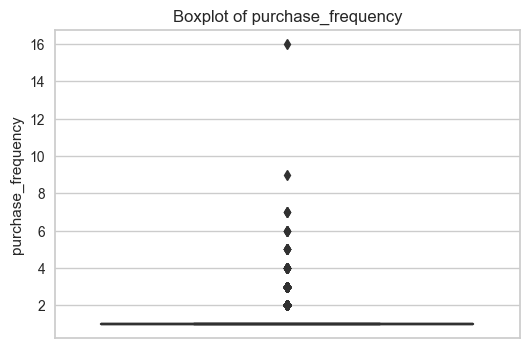

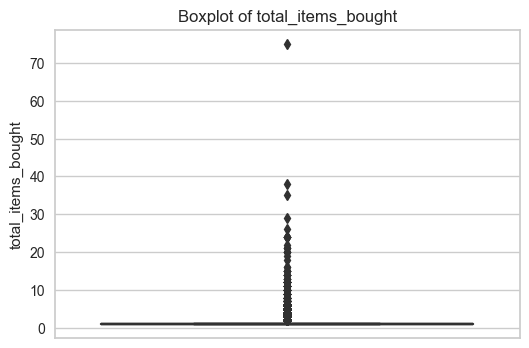

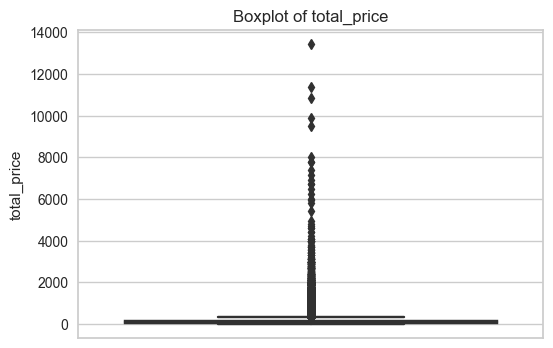

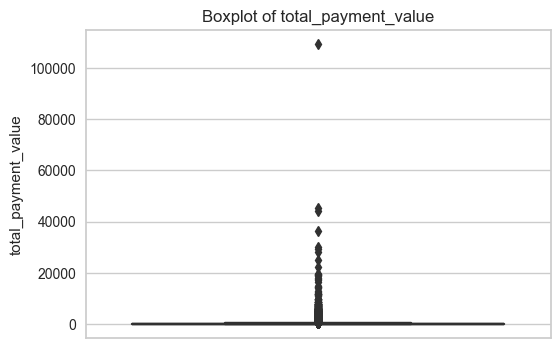

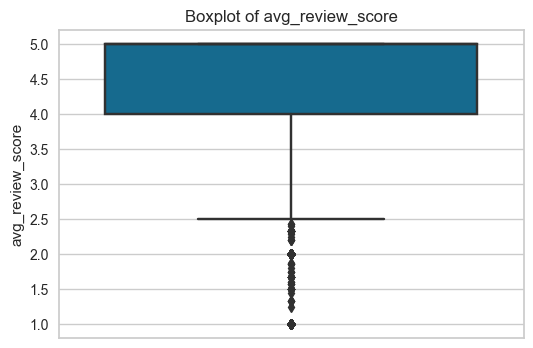

In [31]:
columns_to_plot = ['purchase_frequency', 'total_items_bought', 'total_price', 'total_payment_value', 'avg_review_score']

# Create a plot for each column
for column in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=customer_behavior[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

## Clustering

### Preprocessing

In [32]:
data_cluster = customer_behavior.drop(columns='customer_unique_id')

In [33]:
# Data standardization to handle outliers
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

### Analysis

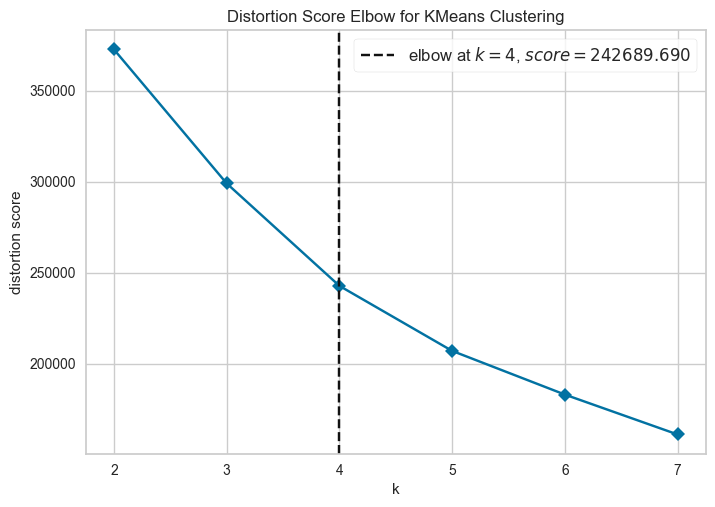

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# Determining the optimal number of clusters
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,8), timings=False)

# Fit data ke visualizer
visualizer.fit(data_scaled)  

# Menampilkan hasil visualisasi
visualizer.show()

In [49]:
from sklearn.metrics import silhouette_score
optimal_clusters = 4 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_cluster['cluster'] = kmeans.fit_predict(data_scaled)

silhouette_avg = silhouette_score(data_scaled, data_cluster['cluster'])
print('Silhouette Score: ', silhouette_avg)

Silhouette Score:  0.5734073045711178


Silhouette score is a metric used to measure how well objects in a cluster are grouped. Silhouette values range from -1 to 1:

* Values close to 1 indicate that objects fit very well into their own cluster and are far away from neighboring clusters.
* A value close to 0 indicates that the object is on the border between two clusters, so it could belong to either cluster.
* A value close to -1 indicates that the object may fit better in an adjacent cluster, rather than their current cluster.

With a Silhouette score of 0.573, it shows that the customer segmentation is quite good 

In [36]:
# Analyze clustering results
data_cluster.groupby('cluster').mean()

,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
cluster,,,,,
0,1.000000,1.242289,132.237721,196.545595,1.892593
1,1.000000,1.129269,122.531201,158.841809,4.741956
2,2.113942,2.800425,258.968507,388.587134,4.165455
3,1.043956,3.392372,1384.976639,2601.138571,3.839370


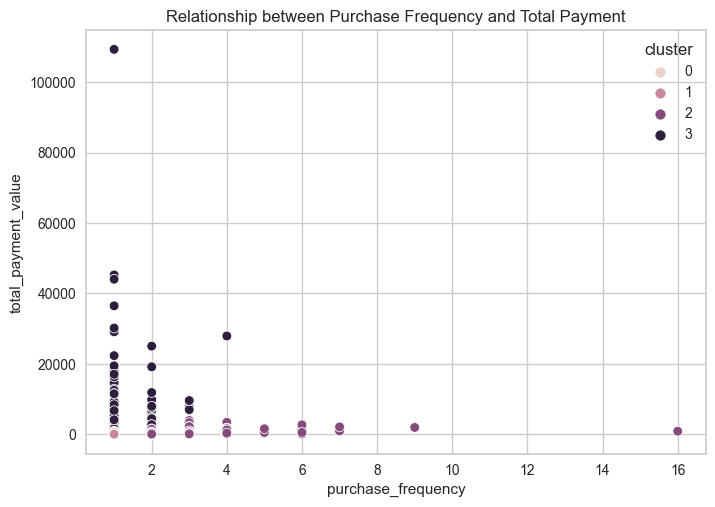

In [48]:
# Scatter plot to see the relationship between purchase frequency and total payment value
sns.scatterplot(x='purchase_frequency', y='total_payment_value', hue='cluster', data=data_cluster)
plt.title('Relationship between Purchase Frequency and Total Payment')
plt.show()

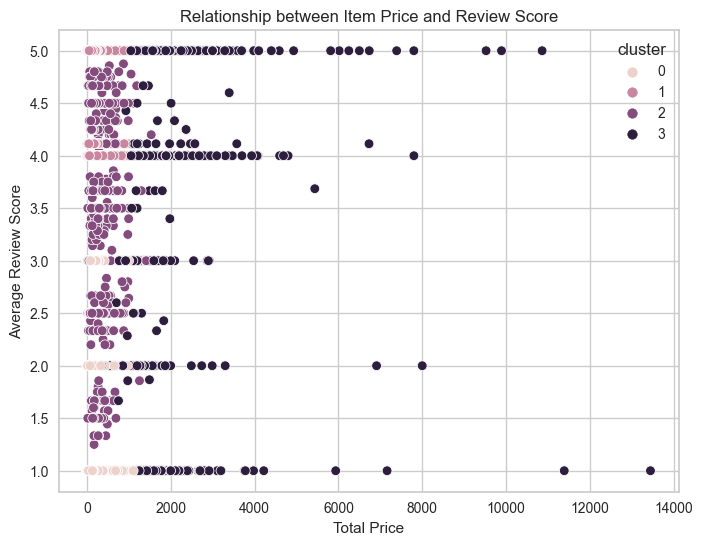

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_price', y='avg_review_score', data=data_cluster, hue='cluster')
plt.xlabel('Total Price')
plt.ylabel('Average Review Score')
plt.title('Relationship between Item Price and Review Score')
plt.show()

## Customer Segmentation Interpretation

Based on the customer segmentation results, four customer clusters were identified based on several variables: **purchase frequency**, **total items bought**, **total price**, **total payment value**, and **avg review score**. The following are interpretations and suggestions based on the values of each cluster:

## cluster 0
- **Purchase Frequency:** 1.00
- **Total Items Bought:** 1.24
- **Total Price:** 132.24
- **Total Payment Value:** 196.55
- **Avg Review Score:** 1.89

**Interpretation:**
- Customers in this cluster tend to buy with low frequency (once only) and buy only a few items. Their purchase value (total price) and payment value are relatively low. Their average reviews are very low, indicating dissatisfaction with the product or service.

**Suggestion:**
- Focus on improving the customer experience for this cluster, for example by improving product or service quality and addressing issues that cause dissatisfaction.
- Consider loyalty or discount programs to encourage them to shop more often or provide better product recommendations.

## Claster 1
- **Purchase Frequency:** 1.00
- **Total Items Bought:** 1.13
- **Total Price:** 122.53
- **Total Payment Value:** 158.84
- **Avg Review Score:** 4.74

**Interpretation:**
- This cluster is similar to Cluster 0 regarding purchase frequency and number of items purchased, but with excellent reviews on average. These customers buy little, yet they are very satisfied with the product or service.

**Suggestion:**
- Maintain the quality of the product or service that has been provided to this cluster.
- Since they are satisfied, they can become potential customers for referral programs or exclusive promotions.

## Claster 2
- **Purchase Frequency:** 2.11
- **Total Items Bought:** 2.80
- **Total Price:** 258.97
- **Total Payment Value:** 388.59
- **Avg Review Score:** 4.17

**Interpretation:**
- Customers in this cluster have a higher purchase frequency and tend to buy more items with a higher total purchase and payment value. They also leave fairly good reviews.

**Suggestion:**
- These customers are active customers who are quite satisfied. You can offer buying packages or bundling to increase the number of items they buy.
- Loyalty programs that award points for every purchase or review can also increase their frequency and total purchases.

## Claster 3
- **Purchase Frequency:** 1.04
- **Total Items Bought:** 3.39
- **Total Price:** 1384.98
- **Total Payment Value:** 2601.14
- **Avg Review Score:** 3.84

**Interpretation:**
- While the frequency of purchase is about the same as the other clusters (once only), customers in this cluster tend to make purchases in large quantities and with a very high total value. Their reviews are quite positive, although not as high as in clusters 1 and 2.

**Suggestion:**
- This cluster has the potential to become high-value customers. Consider providing VIP services or exclusive offers to keep them loyal.
- Identify the factors that cause them to only shop once and look for ways to make them repeat customers.

# General Advice for the Company

- **Offer Personalization:** Use these segmentation results to offer products, services, or promotions that match the needs and characteristics of each cluster.
- **Loyalty Management:** Customers with high purchase frequency and transaction value should be given special attention, such as exclusive loyalty programs, special discounts, or priority customer service.
- **Service Quality Improvement:** For clusters with low reviews, further analysis should be conducted to identify problems and improve service or product quality.
- **Targeted Marketing Programs:** Focus marketing campaigns on clusters that have the potential to increase purchase value.

In [39]:
customer_behavior['cluster']= data_cluster['cluster']
customer_behavior.to_csv('customer_behavior.csv')

## Customer Classification

In [40]:
customer_behavior

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19,4.0,1
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89,5.0,1
...,...,...,...,...,...,...,...
94977,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,1570.00,4134.84,5.0,3
94978,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,84.58,4.0,1
94979,ffff371b4d645b6ecea244b27531430a,1,1,89.90,112.46,5.0,1
94980,ffff5962728ec6157033ef9805bacc48,1,1,115.00,133.69,5.0,1


In [41]:
X = customer_behavior.drop(columns=['customer_unique_id', 'cluster'], axis=1)
y = customer_behavior['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Size of the training data:", X_train.shape, y_train.shape)
print("Size of the testing data:", X_test.shape, y_test.shape)

Size of the training data: (75985, 5) (75985,)
Size of the testing data: (18997, 5) (18997,)


In [42]:
y_train.value_counts()

1    56657
0    15877
2     2224
3     1227
Name: cluster, dtype: int64

In [43]:
#  RandomUnderSampler for class 1 and 0 by 50%
rus = RandomUnderSampler(sampling_strategy={0: int(y_train.value_counts()[0] * 0.5), 1: int(y_train.value_counts()[1] * 0.5)}, random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Sample size of each class after undersampling:")
print(y_train_resampled.value_counts())

Sample size of each class after undersampling:
1    28328
0     7938
2     2224
3     1227
Name: cluster, dtype: int64


In [44]:
# Model initialization
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

logreg.fit(X_train_resampled, y_train_resampled)
rf.fit(X_train_resampled, y_train_resampled)
svm.fit(X_train_resampled, y_train_resampled)

y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("Logistic Regression Accuracy:", accuracy_logreg)
print("Random Forest Accuracy:", accuracy_rf)
print("SVM Accuracy:", accuracy_svm)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9021950834342265
Random Forest Accuracy: 0.9992630415328736
SVM Accuracy: 0.7563825867242197


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00     14079
           2       1.00      1.00      1.00       602
           3       0.97      0.99      0.98       320

    accuracy                           1.00     18997
   macro avg       0.99      1.00      0.99     18997
weighted avg       1.00      1.00      1.00     18997



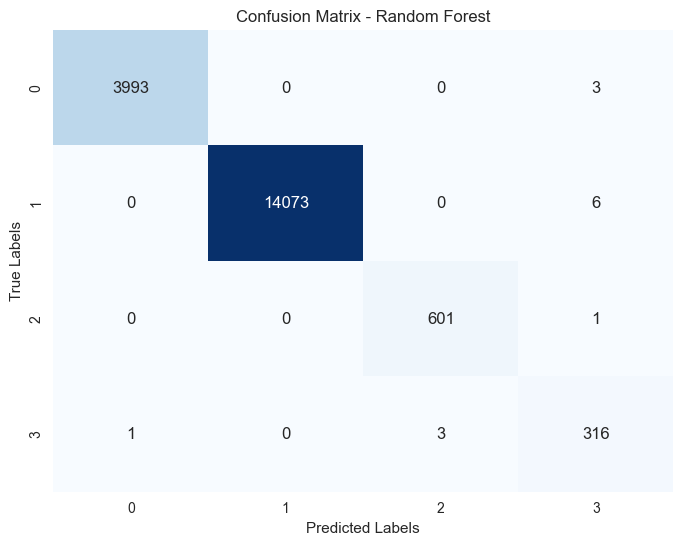

In [45]:
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## Classification Conclusion

* Classification was established to predict which cluster a new or unclustered customer would belong to based on cluster characteristics. 
* Data was trained with 3 classification methods (Random Forest, Logistic Regression and Support Vector Machine)
* The performance of the model in predicting the training data gets 99% accuracy which means the model is very good at predicting customer clusters